
<h1 style ="color : #780eeb; text-align: center;"><b>Projet de Scoring : Identification des clients fragiles</b></h1>
<h3 style ="color : #780eeb; text-align: left;"><b><i>Partie 2 : Modélisation et évaluation</i></b></h3>
<div style="width : 100%;color : #780eeb; text-align : right">Sabine Lohier</div>
<hr style="color : #780eeb" >

In [1]:
# Package pour la gestion des objets json
import json

# Package pour les tableaux et dataframe
import numpy as np
import pandas as pd

# Package pour analyse statistique
from scipy.stats import loguniform

# Package pour la visualisation graphique
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.graph_objs as go

# Packages scikit-learn pour modélisation
from sklearn.preprocessing import ( OrdinalEncoder,
                                   OneHotEncoder,
                                    StandardScaler
)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from  xgboost import XGBClassifier
from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn import set_config

# Package SHAP pour interprétabilité
from shap import (
    TreeExplainer, summary_plot
)
from shap.plots import (scatter, bar, beeswarm)

import pickle

/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/ENV_SC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = None #  pour afficher toutes les colonnes de la base
pd.options.display.max_rows = None  # pour afficher toutes les lignes de la base
pd.set_option('display.max_colwidth', None) # on ne définit pas de largeur max des colonnes afin d'éviter de tronquer leur contenu à l'affichage
set_config(display='diagram') # pour afficher la visualisation graphique des données ou des processus

# Introduction

/!\ Ce notebook succède à 'Variables_Préselection.ipynb'.

A partir des variables explicatives préselectionnées, nous construisons une modélisation permettant de scorer les clients fragiles de notre entreprise de télécommunication.
Pour ce faire nous suivrons les différentes étapes suivantes :
* Evaluation préliminaire de 4 type de modèles de Machine Learning en nous basant sur la métrique Area under the curve ROC (AUC), nous choisissons les 4  modèles suivants :
* * La régression logistique
* * La SVC avec un kernel linéaire
* * Une forêt aléatoire
* * le modèle type boosting - XGBoost.

* Fine-tuning des hyperparamètres de ces 4 modèles en utilisant une stratégie de 'randomized search'

* Evaluation des 4 modèles optimisés sur les données de test

* Sélection du meilleur modèle en fonction de sa robustesse, de sa calibration et de sa propension à juger de la surconcentration des client cibles.

* Pour enfin interpréter les résultats du modèle retenu selon une approche globale, à savoir en identifiant l'importance de chaque variable pour les prédictions finales en utilisant les techniques de `permutation feature importance` et de SHAP.

# 1. Importation des données

In [3]:
# Définition de la seed permettant la reproductibilité des résultats
seed = 42

In [4]:
# Chargement du json 'variable_types.json' regroupant les variables explicatives par type de variable
with open("./data/ML_input/variable_types.json", "r") as read_file:
    json_ = json.load(read_file)

# Affichage de l'objet json_
print(json.dumps(json_, indent=4, ensure_ascii=False))

{
    "bool": [
        "online_security",
        "paperless_billing"
    ],
    "cat_num": [
        "age_bins",
        "family_size_bins",
        "number_of_referrals_bins",
        "tenure_in_months_bins",
        "total_of_services_add"
    ],
    "cat": [
        "contract",
        "internet_type",
        "offer",
        "payment_method"
    ],
    "num": [
        "monthly_charge"
    ]
}


In [5]:
# Importation des données de train et de test
df_train = pd.read_csv("./data/ML_input/train/df_train.csv", sep=",",keep_default_na=False,na_values=['NaN'])
df_test = pd.read_csv("./data/ML_input/train/df_test.csv", sep=",",keep_default_na=False,na_values=['NaN'])

In [6]:
# Affichage des infos
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   online_security           4126 non-null   object 
 1   paperless_billing         4126 non-null   object 
 2   contract                  4126 non-null   object 
 3   internet_type             4126 non-null   object 
 4   offer                     4126 non-null   object 
 5   payment_method            4126 non-null   object 
 6   age_bins                  4126 non-null   int64  
 7   family_size_bins          4126 non-null   int64  
 8   number_of_referrals_bins  4126 non-null   int64  
 9   tenure_in_months_bins     4126 non-null   int64  
 10  total_of_services_add     4126 non-null   int64  
 11  monthly_charge            4126 non-null   float64
 12  churn_value               4126 non-null   int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 419.2+ KB


In [7]:
# Séparation des variables explicatives de la variable cible
y_train = df_train["churn_value"]
X_train = df_train.drop(columns="churn_value")

y_test = df_test["churn_value"]
X_test = df_test.drop(columns="churn_value")

# Définition des listes des variables selon leur type
bool_cols = json_["bool"] # variables booléennes
cat_cols = json_["cat"]  # variables catégorielles textuelles
cat_num_cols = json_["cat_num"] # variables catégorielles ordinales
num_cols = json_["num"] # variable numériques

# 2 Modélisation prédictive

## 2.1 Préselection de modèles de Machine Learning

Comme spécifié en introduction, nous allons tester dans un premier temps les performances de 4 grandes familles de modèles :
* la `régression logistique`
* le `SVM` avec un kernel linéaire
* Le modèle de bagging : `RandomForest`
* Le modèle de gradient boosting : `XGBoost`

## 2.2 Pipeline de transformation

Nous avons vu au cours de l'analyse de nos variables que celles-ci ne présentent pas de valeur manquante néanmoins nous créons un pipeline de tranformation destiné à généraliser notre modèle à d'autres données, par conséquent nous définissons également une stratégie d'imputation pour chacune des variables selon leur type :
* On impute la catégorie la plus fréquente aux valeur manquantes des variables catégorielles et booléennes,
* * Les variables booléennes sont ensuite encodées ordinalement, à savoir "No"-> 0, "Yes"-> 1,
* * Les variables catégorielles textuelles sont encodées selon un one-hot-encodeur
* On impute la moyenne statistique aux valeurs manquantes de notre variable numérique, celle-ci est ensuite normalisée par un standardscaler.

In [8]:
# Initialisation des Imputers
num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Initialisation des encoders
ordinal_encoder = OrdinalEncoder(categories= [["No", "Yes"]]*(len(json_["bool"])))
one_hot_encoder = OneHotEncoder()

# Initialisation du Standard scaler
scaler = StandardScaler()

# Création des pipelines de transformation
cat_ordinal_transformer = make_pipeline(  ordinal_encoder) # variables booléennes
cat_one_hot_encoder_transformer = make_pipeline( cat_imputer, one_hot_encoder) # variables catégorielles textuelles
cat_transformer = make_pipeline( cat_imputer) # variables catégorielles ordinales
num_transformer = make_pipeline( num_imputer, scaler ) # variable numérique

# Définition du préprocesseur
preprocessor = ColumnTransformer(
        transformers=[
              ("cat_ord", cat_ordinal_transformer, json_["bool"]),
              ("cat_oh", cat_one_hot_encoder_transformer,json_["cat"]),
              ("cat_", cat_transformer, json_["cat_num"]),
              ("numerical", num_transformer, json_["num"])
        ]
)

## 2.3 Définition des modèles candidats

In [9]:
# pour chacun des modèles, nous avons également défini l'espace de recherche des hyperparamètres
# qui sera utilisé pour le finetuning.
clf_models  = { "Régression Logistique" :  {"model": LogisticRegression(max_iter = 1000,  penalty = 'l2',
                                                                        random_state= seed),
                                              "params" : {"classifier__solver" : ["lbfgs", "liblinear"],
                                                        "classifier__C" : loguniform(0.1, 10),
                                                        "classifier__tol" : loguniform(0.0001,0.3)
                                                        }
                                             },
               "SVC Linéaire" :{"model" :  SVC(kernel='linear', random_state=seed,
                                               class_weight="balanced", probability=True),
                                "params" : { "classifier__C" : loguniform(0.1, 10),
                                           "classifier__tol" : loguniform(0.0001,0.3)
                                           }
                                },
               "XGBoost" :{"model" :  XGBClassifier(random_state =seed),
                            "params" : {"classifier__n_estimators" : range(100,600,50),
                                        "classifier__max_depth" : range(3,7,1),
                                        "classifier__eta" : loguniform(0.01,0.3),
                                        "classifier__lambda" : loguniform(0.1,10)
                                        }
                            },
               "RandomForest" :{"model" :  RandomForestClassifier(random_state=seed),
                                 "params" : {"classifier__max_depth" : range(3,7,1),
                                 "classifier__n_estimators" : range(100,600,50)}
                                 }
               }

## 2.4 Entraînement et pré-évaluation des modèles

Nous pré-évaluons les performances de nos modèles sans hyper-paramétrisation par le biais d'une cross-validation basée sur le partitionnement de notre base de train en 5 échantillons.

In [10]:
# Itération sur les modèles sélectionnés
for key, model in clf_models.items() :
        # Définition du pipeline
        pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model["model"])])

        print(f"\n\n############################ {key} ############################")
        display(pipe)

        # Cross validation du modèle, cv = 5
        # Métrique : roc_auc
        roc_auc = cross_val_score(pipe,X_train, y_train,cv=5, n_jobs=5, scoring ='roc_auc')
        print(f"Résultats pour le modèle {key} non fine-tuné :\n AUC moyenne de {round(roc_auc.mean(),4)} ({roc_auc})")



############################ Régression Logistique ############################


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'Yes'],
                                                                                              ['No',
                                                                                               'Yes']]))]),
                                                  ['online_security',
                                                   'paperless_billing']),
                                                 ('cat_oh',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['contract', 'internet_...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['age_bins',
                                                   'family_size_bins',
                                                   'number_of_referrals_bins',
                                                   'tenure_in_months_bins',
                                                   'total_of_services_add']),
                                                 ('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charge'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

Résultats pour le modèle Régression Logistique non fine-tuné :
 AUC moyenne de 0.8689 ([0.86707056 0.86957313 0.8827139  0.8538118  0.87150673])


############################ SVC Linéaire ############################


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'Yes'],
                                                                                              ['No',
                                                                                               'Yes']]))]),
                                                  ['online_security',
                                                   'paperless_billing']),
                                                 ('cat_oh',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['contract', 'internet_...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['age_bins',
                                                   'family_size_bins',
                                                   'number_of_referrals_bins',
                                                   'tenure_in_months_bins',
                                                   'total_of_services_add']),
                                                 ('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charge'])])),
                ('classifier',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])

Résultats pour le modèle SVC Linéaire non fine-tuné :
 AUC moyenne de 0.8639 ([0.86685931 0.86860296 0.87533818 0.85220969 0.85664949])


############################ XGBoost ############################


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'Yes'],
                                                                                              ['No',
                                                                                               'Yes']]))]),
                                                  ['online_security',
                                                   'paperless_billing']),
                                                 ('cat_oh',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['contract', 'internet_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Résultats pour le modèle XGBoost non fine-tuné :
 AUC moyenne de 0.8759 ([0.86092166 0.88142736 0.88370388 0.87535707 0.87823633])


############################ RandomForest ############################


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'Yes'],
                                                                                              ['No',
                                                                                               'Yes']]))]),
                                                  ['online_security',
                                                   'paperless_billing']),
                                                 ('cat_oh',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['contract', 'internet_...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['age_bins',
                                                   'family_size_bins',
                                                   'number_of_referrals_bins',
                                                   'tenure_in_months_bins',
                                                   'total_of_services_add']),
                                                 ('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charge'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Résultats pour le modèle RandomForest non fine-tuné :
 AUC moyenne de 0.8738 ([0.8664104  0.87607249 0.88991581 0.85747699 0.87891269])


Ces résultats nous indiquent dans l'ensemble de très bonnes performances des 4 modèles candidats excédant tous un AUC de 0.86.

Notons que les performances des 2 modèles ensemblistes sont légèrement supérieures.

## 2.5 Hyper-paramétrisation

Dans cette section, nous cherchons à optimiser les performances des 4 modèles en terme de score en déterminant les combinaisons idéales des hyperparamètres définis précédemment dans le dictionnaire `clf_models`.

Nous recourons pour ce faire à la technique de `Randomized Search` par cross-validation de la base d'entraînement sur 5 sous-échantillons.


In [11]:
# Finetuning du modèle 'model', stratégie de randomizedSearch par cross validation n = 5:
#   Définition du pipeline
#   Cross validation de RandomizedSearchCV sur la base (X, y)
#   Affichage du score optimum, de la combinaison d'hyperparamètres correspondante
#   Affichage des 8 meilleures combinaisons d'hyperparamètres
# Output : df contenant la liste des 8 meilleures combinaisons de paramètres + scores associés
def do_RandomizedSearch(preprocessor, model_name, model, X, y, seed) :
    pipe_ = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier',model["model"])])
    rscv = RandomizedSearchCV(estimator = pipe_, param_distributions= model["params"], cv = 5,
                               n_jobs = 5,n_iter=40,return_train_score = True,
                               scoring = "roc_auc" ,random_state = seed)
    rscv.fit(X, y)
    df_score_params = pd.DataFrame(rscv.cv_results_).sort_values("mean_test_score", ascending = False)
    print(f"Modèle { model_name} avec RandomizedSearch : ")
    print(f"La meilleure combinaison d'hyperparamètres est :\n{rscv.best_params_}")
    print(f"\n  -> Score AUC optimisé : {round(rscv.best_score_,4)}")
    display(df_score_params[["params","mean_test_score","mean_train_score"]].head(n=8) )
    return  df_score_params[["params"]].head(n=8).values.ravel()


# Hyperparamétrisation des 4 modèles :
for key, model in clf_models.items():
    print(f"\n\n############################ {key} ############################")
    df_score_params = do_RandomizedSearch(preprocessor,key,model,
                                            X_train, y_train, seed)
    # on enregistre dans le dictionnaire clf_models df
    # contenant la liste des 8 meilleures combinaisons de paramètres + scores associés
    model["best_params"] = df_score_params




############################ Régression Logistique ############################
Modèle Régression Logistique avec RandomizedSearch : 
La meilleure combinaison d'hyperparamètres est :
{'classifier__C': 0.5611516415334505, 'classifier__solver': 'lbfgs', 'classifier__tol': 0.00043433517920812126}

  -> Score AUC optimisé : 0.869


,params,mean_test_score,mean_train_score
0,"{'classifier__C': 0.5611516415334505, 'classifier__solver': 'lbfgs', 'classifier__tol': 0.00043433517920812126}",0.868990,0.872236
23,"{'classifier__C': 1.100698868558953, 'classifier__solver': 'liblinear', 'classifier__tol': 0.0013527358752820956}",0.868937,0.872310
18,"{'classifier__C': 2.113705944064573, 'classifier__solver': 'liblinear', 'classifier__tol': 0.003008281879774911}",0.868929,0.872334
24,"{'classifier__C': 0.59890036722543, 'classifier__solver': 'liblinear', 'classifier__tol': 0.007526186647947119}",0.868929,0.872252
21,"{'classifier__C': 0.6170217483403153, 'classifier__solver': 'liblinear', 'classifier__tol': 0.011994184484868678}",0.868922,0.872248
28,"{'classifier__C': 3.5033984911586877, 'classifier__solver': 'liblinear', 'classifier__tol': 0.0010483202387600089}",0.868902,0.872349
20,"{'classifier__C': 8.692991511139551, 'classifier__solver': 'liblinear', 'classifier__tol': 0.0036631074375033435}",0.868896,0.872345
11,"{'classifier__C': 9.25681899206688, 'classifier__solver': 'lbfgs', 'classifier__tol': 0.0001450486587761426}",0.868891,0.872362




############################ SVC Linéaire ############################
Modèle SVC Linéaire avec RandomizedSearch : 
La meilleure combinaison d'hyperparamètres est :
{'classifier__C': 0.1025756397418565, 'classifier__tol': 0.06846336881836969}

  -> Score AUC optimisé : 0.8651


,params,mean_test_score,mean_train_score
36,"{'classifier__C': 0.1025756397418565, 'classifier__tol': 0.06846336881836969}",0.865096,0.867432
35,"{'classifier__C': 3.5033984911586877, 'classifier__tol': 0.0004908609910734265}",0.864905,0.867278
29,"{'classifier__C': 0.12315571723666023, 'classifier__tol': 0.0013527358752820956}",0.864900,0.867436
5,"{'classifier__C': 0.10994335574766201, 'classifier__tol': 0.23577305025968318}",0.864892,0.867513
22,"{'classifier__C': 0.3292759134423616, 'classifier__tol': 0.020121961636102876}",0.864813,0.867317
20,"{'classifier__C': 0.17541893487450796, 'classifier__tol': 0.005269751777340594}",0.864750,0.867411
21,"{'classifier__C': 0.1171593739230706, 'classifier__tol': 0.14515008597840265}",0.864701,0.867216
28,"{'classifier__C': 0.15030900645056822, 'classifier__tol': 0.0004802376182711903}",0.864659,0.867399




############################ XGBoost ############################
Modèle XGBoost avec RandomizedSearch : 
La meilleure combinaison d'hyperparamètres est :
{'classifier__eta': 0.02692655251486473, 'classifier__lambda': 1.6738085788752133, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}

  -> Score AUC optimisé : 0.8999


,params,mean_test_score,mean_train_score
6,"{'classifier__eta': 0.02692655251486473, 'classifier__lambda': 1.6738085788752133, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}",0.899876,0.926011
7,"{'classifier__eta': 0.03672338759552654, 'classifier__lambda': 9.25681899206688, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}",0.898979,0.914454
17,"{'classifier__eta': 0.05879431781724018, 'classifier__lambda': 8.362652463906244, 'classifier__max_depth': 3, 'classifier__n_estimators': 150}",0.898909,0.917085
19,"{'classifier__eta': 0.027392514012725373, 'classifier__lambda': 0.21405919019849057, 'classifier__max_depth': 3, 'classifier__n_estimators': 400}",0.898722,0.926311
10,"{'classifier__eta': 0.037094276752507684, 'classifier__lambda': 0.10762979285747973, 'classifier__max_depth': 4, 'classifier__n_estimators': 250}",0.897574,0.940782
26,"{'classifier__eta': 0.02545642421255076, 'classifier__lambda': 1.3258269776216491, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}",0.896963,0.945523
30,"{'classifier__eta': 0.011128194768838964, 'classifier__lambda': 1.8742210985555698, 'classifier__max_depth': 6, 'classifier__n_estimators': 250}",0.896407,0.933649
34,"{'classifier__eta': 0.014316201862826452, 'classifier__lambda': 0.81859510052222, 'classifier__max_depth': 6, 'classifier__n_estimators': 250}",0.895978,0.943399




############################ RandomForest ############################
Modèle RandomForest avec RandomizedSearch : 
La meilleure combinaison d'hyperparamètres est :
{'classifier__n_estimators': 150, 'classifier__max_depth': 6}

  -> Score AUC optimisé : 0.8877


,params,mean_test_score,mean_train_score
31,"{'classifier__n_estimators': 150, 'classifier__max_depth': 6}",0.887673,0.908553
34,"{'classifier__n_estimators': 300, 'classifier__max_depth': 6}",0.887620,0.909000
33,"{'classifier__n_estimators': 250, 'classifier__max_depth': 6}",0.887560,0.908936
32,"{'classifier__n_estimators': 200, 'classifier__max_depth': 6}",0.887526,0.908748
35,"{'classifier__n_estimators': 350, 'classifier__max_depth': 6}",0.887523,0.908961
37,"{'classifier__n_estimators': 450, 'classifier__max_depth': 6}",0.887510,0.908922
38,"{'classifier__n_estimators': 500, 'classifier__max_depth': 6}",0.887506,0.908887
39,"{'classifier__n_estimators': 550, 'classifier__max_depth': 6}",0.887383,0.908774


Plusieurs points issus des résultats ci-dessus sont à distinguer :
* L’hyperparamétrisation n’influence qu’à la marge les performances des modèles de régression logistique et SVC à kernel linéaire, tandis que les modèles RandomForest et de XGBoost se trouvent plus significativement optimisés en terme de score AUC
* Les écarts entre la moyenne des scores obtenus sur le set de train et de test, sont légèrement plus prononcés (de l'ordre de 0.02) pour les modèles ensemblistes, tandis que celui-ci est de l’ordre de 0.002 pour la régression logistique et la SVC.


Les combinaisons d’hyperparamètres que nous retenons sont les suivantes:

* régression logistique :

C = 1.1, solver  = “liblinear”, tol = 0.000434 : c’est la deuxième meilleure combinaison, elle a l’avantage d’être moins pénalisante que la première tout en ayant des performances identiques.

* SVC:

C = 3.5, tol =  0.000491 : C’est aussi la deuxième meilleure combinaison, elle a également l’avantage d’être moins pénalisante que la première tout en ayant des performances identiques.

* Xgboost :

lambda = 9.2568, eta = 0.0367, 200 arbres de décision de profondeur maximale = 3 : c’est la deuxième meilleure combinaison qui permet d’obtenir un modèle légèrement plus robuste que pour la meilleure combinaison d’hyperparamètres.

* Random Forest :

150 arbres de décisions de profondeur maximale égale à 6 :  c’est la meilleure combinaison et elle a l’avantage d’être basée sur un nombre d'arbres de décision relativement bas.



## 2.6 Evaluation finale

Nous nous proposons ici d'évaluer les performances de nos 4 modèles hyperparamétrisés sur la base de test.

Nous regarderons également le taux de réponses positives capturées par les modèles par rapport  à celui qui serait attendu au cours d'une sélection aléatoire par le biais d'une étude comparative de leurs courbes lift.

Nous évaluerons également la calibration de chacun d'entre eux en calculant l'indicateur de Spiegelhalter.

In [12]:
# fonction qui définit le pipeline en fonction du 'model'
#              charge les hyperparamètres retenus (params)
#              entraîne le model avec X et y
# renvoie le modèle entraîné
def fit_model (preprocessor, model_name, model, params, X, y) :
    pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)])
    pipe.set_params(**params)
    pipe.fit(X, y)
    #pickle.dump(pipe, open(model_name + ".sav", 'wb'))
    return pipe

# fonction qui évalue le modèle entraîné sur les bases train et test
# et retourne les probabilités prédites pour le jeu de test
def model_evaluation (pipe, model, X_train, y_train, X_test, y_test) :
    y_train_proba = pipe.predict_proba(X_train )
    y_test_proba = pipe.predict_proba(X_test)
    auc_train = roc_auc_score(y_train, y_train_proba[:,1])
    auc_test = roc_auc_score(y_test, y_test_proba[:,1])
    print(f"Score AUC pour le modèle {model} optimisé : ")
    print(f"{'-'*100}")
    print(f"Train  : {round(auc_train,4)},\n Test  : {round(auc_test,4)}")
    return y_test_proba

In [13]:
# fonction calculant le score de Spiegelhalter
def score_spiegelhalter(y_true, y_pred):
    numerateur = np.sum(np.multiply(y_true - y_pred, 1 - 2 * y_pred))
    denominateur = np.sqrt(
        np.sum(
            np.multiply(
                np.multiply(np.power(1 - 2 * y_pred, 2), y_pred), 1 - y_pred
            )
        )
    )

    return numerateur / denominateur

In [14]:
# fonction de calcul de la courbe de lift
def lift_curve_data(y_true, y_pred):

    # Trier le vecteur des labels (y_true) et celui des
    # proba (y_pred) par ordre croissant de la proba :
    # respectivement y_pred et y_test_sorted.
    sorted_score = np.argsort(y_pred)[::-1]

    # Vérifier que y_true et y_pred sont des arrays
    if not isinstance(y_true, np.ndarray):
        y_true = y_true.to_numpy()
    if not isinstance(y_pred, np.ndarray):
        y_pred = y_pred.to_numpy()

    y_true = y_true[sorted_score]
    y_pred = y_pred[sorted_score]

    # Créer un dataframe contenant les deux vecteurs : lift_df
    # Nommer les colonnes en y_pred et y_true
    lift_df = pd.DataFrame({"y_pred": y_pred, "y_true": y_true})

    # Découper le jeu de données en quantile (centile ici) : perc_bins
    lift_df["perc"] = (lift_df.index / lift_df.shape[0]) * 100
    lift_df["perc_bins"] = pd.cut(lift_df["perc"], np.arange(0, 101, 1))

    # Grouper par intervalle et calculer l'effectif
    # des y = 1 dans chaque intervalle : y_test_sum
    lift_df = (lift_df.groupby(["perc_bins"], as_index=False)
               .agg(y_true_sum=("y_true", "sum"))
              )
    # Calculer l'effectif cumulé des y = 1 : y_true_cusum
    lift_df["y_true_cumsum"] = lift_df["y_true_sum"].cumsum()

    # Calculer la concentration (rapport de y_true_cusum par le total des y = 1) : concentration
    lift_df["concentration"] = (lift_df["y_true_cumsum"] / lift_df["y_true_sum"].sum())*100

    # Rajouter un point de coordonnées (0, 0) sur la première ligne.
    # pour la représentation graphique.
    zeros_df = pd.DataFrame(np.zeros((1, 4)), columns=lift_df.columns)
    lift_df = pd.concat([zeros_df, lift_df]).reset_index(drop=True)

    return lift_df

In [15]:
fig = go.Figure()
colors = ["#fcb735", "#40b0bf", "#175b91", "#053363"]

for i, (key, model) in enumerate(clf_models.items()) :
        # On récupère les hyperparamètres retenus
        hyperparams = model["best_params"][1]
        if i == 2 : # pour la random forest on récupère la 1ere combinaison d'hyperparamètres
                hyperparams = model["best_params"][0]
        # entraînement du modele
        pipe = fit_model (preprocessor, key, model["model"],
                          hyperparams, X_train, y_train)
        # Evaluation du modèle
        y_test_proba =  model_evaluation (pipe, key, X_train, y_train, X_test, y_test)
        model["y_test_proba"] = y_test_proba[:,1]
        # Calcul du score de spiegelhalter sur le modèle non calibré
        print(f"Score de Spiegelhalter avant calibration: {round(score_spiegelhalter(y_test, y_test_proba[:,1]),2)}")

        # Création de la courbe lift
        lift_df = lift_curve_data(y_test, y_test_proba[:,1])
        fig.add_trace( go.Scatter(x=lift_df.index, y=lift_df["concentration"], mode='lines', name=key, line=dict(width=4), line_color = colors[i]))


# Visualisation des 4 courbes lift
fig.add_trace(go.Scatter(
    x=[0, 100],   y=[0, 100],  line = dict(color='grey', width=2, dash='dash'), name="Aléatoire")
)
fig.update_layout(
    xaxis=dict(
        showgrid=True,
        constrain='domain',
        color = "black",
        tickvals=[0, 20, 40, 60, 80, 100]
    ),
    yaxis=dict(
        showgrid=True,
        scaleanchor="x",
        scaleratio=1
    ),
    xaxis_title='% des clients classés par ordre des scores décroissants',
    yaxis_title='% de la cible',
    margin=dict(l=0, r=0, t=40, b=0),
    width=700, height=400
)
fig.update_layout(
        title= {"text" :"Courbes de lift",'x': 0.5},

                   legend_title_text='Modèles : ')
fig.update_xaxes(
    range=[0, 100],
    rangemode="tozero"
)
fig.update_yaxes(
    range=[0, 100],
    rangemode="tozero"
)
# Affichage du graphique
fig.show()


Score AUC pour le modèle Régression Logistique optimisé : 
----------------------------------------------------------------------------------------------------
Train  : 0.8719,
 Test  : 0.8856
Score de Spiegelhalter avant calibration: -0.68


/tmp/ipykernel_10919/1358770484.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Score AUC pour le modèle SVC Linéaire optimisé : 
----------------------------------------------------------------------------------------------------
Train  : 0.8671,
 Test  : 0.885
Score de Spiegelhalter avant calibration: -2.17
Score AUC pour le modèle XGBoost optimisé : 
----------------------------------------------------------------------------------------------------
Train  : 0.9232,
 Test  : 0.9126
Score de Spiegelhalter avant calibration: -1.59


/tmp/ipykernel_10919/1358770484.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_10919/1358770484.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Score AUC pour le modèle RandomForest optimisé : 
----------------------------------------------------------------------------------------------------
Train  : 0.9053,
 Test  : 0.903
Score de Spiegelhalter avant calibration: -4.67


/tmp/ipykernel_10919/1358770484.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Les résultats ci-dessus indiquent que :
* Les 4 modèles présentent de très bons résultats et ont une bonne capacité à généraliser aux nouvelles données. Le modèle le plus performant en terme de score AUC est le modèle XGBoost.
* Ces modèles sont tous les 4 robustes, la différence maximum entre le score AUC sur la base de test et de train étant de 0.0168 (pour le modèle SVC linéaire).
* Seul le modèle de régression logistique est naturellement correctement calibré avec un score de SpiegelHalter de 0.68 en valeur absolue alors que les 3 autres modèles ont un score de spiegelhalter excèdant nettement 2 en valeur absolue.
* Les courbes de lift sont globalement très proches pour les 4 modèles avec une tendance sur les premiers 20 % des clients à être meilleurs pour les 2 modèles ensemblistes.
Notons par ailleurs que le lift de ces 2 modèles sont relativement correct :
* * Pour le modèle XGBoost, en ciblant 10% des clients, on parvient à identifier 33.1% de la cible, soit 3.3 fois plus que pour un ciblage aléatoire.
* * De même avec le modèle RandomForest, en ciblant 10% des clients, on parvient à identifier 34.2% de la cible.


Nous sélectionnons le modèle XGBoost pour la suite de notre modélisation.

## 2.7 Calibration

### 2.7.1 Modèle XGBoost initial

Comme nous l'avons relevé dans la section ci-dessus, nous obtenons un score de Spiegelhalter de -2.17 pour notre modèle entraîné XGBoost. Ce dernier témoigne d'une calibration insuffisante.

Regardons la courbe de calibration du modèle reflétant la proportion de la cible en fonction de la moyenne des probabilités afin de valider le résultat de cet indicateur :

In [16]:
# fonction de calcul de la courbe de calibration via sklearn
def sklearn_calibration(y_true, y_pred, n_bins=20):

    prob_true, prob_pred = calibration_curve(
        y_true, y_pred,
        n_bins=n_bins,
        strategy="quantile"
    )

    df = pd.DataFrame({"prob_pred":prob_pred, "prob_true":prob_true})

    return df

In [17]:
# Fonction qui génère la courbe de calibration issue du (des) dataframes cal_df_init (caf_cal)
def plot_calibration_curve (cal_df_init, cal_df = None) :
    # Création de la figure
    fig, axe = plt.subplots(figsize=(5,5), constrained_layout=True)

    # Création du scatterplot
    sns.scatterplot(ax=axe, data=cal_df_init, x = 'prob_pred', y="prob_true", legend = True, color = "#CC226E")#,palette = palette, legend = False)
    if cal_df is not None:
        sns.scatterplot(ax=axe, data=cal_df, x = 'prob_pred', y="prob_true", legend = True, color = "#226ECC")#,palette = palette, legend = False)

    # Ajout de la ligne y = x
    sns.lineplot(ax=axe,  x = [0, 1], y=[0,1], color = "grey", linestyle='--', alpha=0.5)

    # Gestion des axis et labels
    axe.set_xlabel("Probabilité moyenne")
    axe.set_ylabel("Proportion de la cible")

    # Ajout des lignes horizontales
    axe.grid(visible=True, which='major', axis='y')
    axe.spines['top'].set_visible(False)
    axe.spines['right'].set_visible(False)
    axe.spines['bottom'].set_visible(True)
    axe.spines['left'].set_visible(False)

    # Création de la légende
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Avant calibration', markerfacecolor='#CC226E', markersize=7),
        Line2D([0], [0], marker='o', color='w', label='Après calibration', markerfacecolor='#226ECC', markersize=7)
    ]
    if cal_df is not None:
        axe.legend(handles=legend_elements, loc='upper left', borderaxespad=0, frameon=False ,bbox_to_anchor= (0.04, 0.9))

    # Ajout du titre principal
    fig.suptitle(f'Courbe de calibration.')

    fig.show()

/tmp/ipykernel_10919/3373217357.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



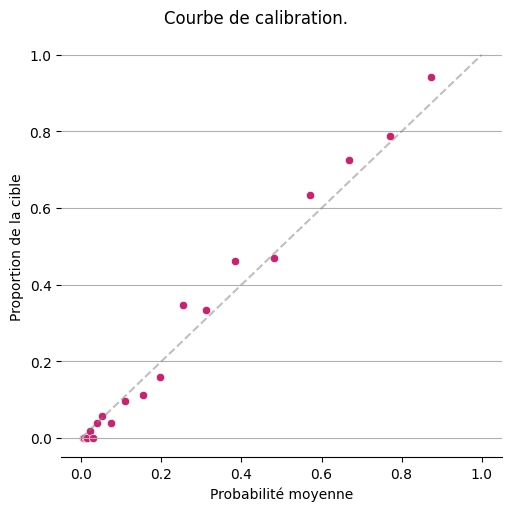

In [18]:
# Création de la courbe de calibration
calibration_df_init = sklearn_calibration(y_test, clf_models["XGBoost"]["y_test_proba"], 20)
plot_calibration_curve (calibration_df_init)

La courbe de calibration vient confirmer le fait que le modèle n'est pas correctement calibré.

### 2.7.2 Résultats après calibration

Compte tenu de la faible volumétrie d'observations dans le jeu de test ~ 1000 observations et afin d'éviter tout risque de surapprentissage, durant la phase calibration de notre modèle nous choisissons de le réentraîner tout en le calibrant.
Notre stratégie de calibration sera basée sur une régression isotonique.

/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/ENV_SC/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:35:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__eta", "classifier__lambda", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/ENV_SC/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:35:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__eta", "classifier__lambda", "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/ENV_SC/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:35:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__eta", "classifier__lambda", "classifier__max_depth", "classifier__n_estimators" } are not used.

  w

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'Yes'],
                                                                                              ['No',
                                                                                               'Yes']]))]),
                                                  ['online_security',
                                                   'paperless_billing']),
                                                 ('cat_oh',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['contract', 'internet_...
                                                                eta=0.02692655251486473,
                                                                eval_metric=None,
                                                                feature_types=None,
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                lambda=1.6738085788752133,
                                                                learning_rate=None,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=4,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan, ...),
                                        method='isotonic', n_jobs=5))])

Score AUC pour le modèle XGBoost optimisé : 
----------------------------------------------------------------------------------------------------
Train  : 0.9246,
 Test  : 0.9118
Score de Spiegelhalter : 0.56


/tmp/ipykernel_10919/3373217357.py:36: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



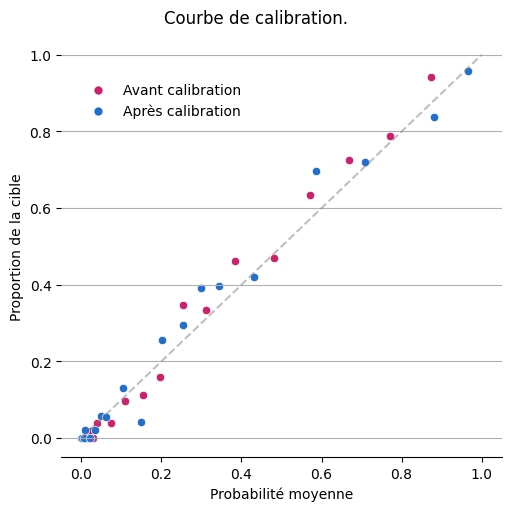

In [19]:
# On récupère le modèle XGBoost définit précédemment
# et les hyperparamètres optimums
xgb_clf = clf_models["XGBoost"]["model"]
hyperparams = clf_models["XGBoost"]["best_params"][1]
xgb_clf.set_params(**hyperparams)

# Instanciation du modèle de calibration
calibration_clf = CalibratedClassifierCV(estimator = xgb_clf, method = "isotonic", cv = 5, n_jobs = 5)
calibration_xgb =  Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', calibration_clf)])

# Entraînement du modèle de calibration
calibration_xgb.fit(X_train, y_train)
display(calibration_xgb)

# Evaluation du modèle
y_test_proba_cal =  model_evaluation (calibration_xgb, "XGBoost", X_train, y_train, X_test, y_test)

# Calcul du score de spiegelhalter sur le modèle  calibré
print(f"Score de Spiegelhalter : {round(score_spiegelhalter(y_test, y_test_proba_cal[:,1]),2)}")

# Affichage de la courbe de calibration du modèle avant et après calibration
calibration_df = sklearn_calibration(y_test, y_test_proba_cal[:,1], 20)
plot_calibration_curve (calibration_df_init, calibration_df)


Cette phase de calibration a significativement amélioré nos résultats en terme de calibration. Nous obtenons désormais un score de Spiegelhalter de 0.56 en valeur absolue tout en maintenant les performances du modèle. En revanche les effets de la calibration sur la courbe de calibration n'est pas flagrant.

## 2.8 Prédiction finale - base `eval`

Dans cette section, nous utilisons notre modèle fine-tuné et calibré pour prédire les scores et la valeur de churn relative à chaque client.
Nous trions ensuite les clients selon leur score décroissant et exportons les prédictions finales dans un csv.

In [20]:
# Importation des données eval
df_eval = pd.read_csv("./data/intermediate/eval/df_telco.csv", sep=",",keep_default_na=False,na_values=['NaN'])
X_eval = pd.read_csv("./data/ML_input/eval/df_eval.csv", sep=",",keep_default_na=False,na_values=['NaN'])

# Prédiction de la target
y_eval_pred_proba =  calibration_xgb.predict_proba(X_eval)
y_eval_pred =  calibration_xgb.predict(X_eval)

# Stockage des résultats dans un dataframe
df_eval_pred = pd.DataFrame({"customer_id" : df_eval["customer_id"],
                                   "y_pred_proba": y_eval_pred_proba[:,1],
                                   "churn_value": y_eval_pred})

# On trie les clients par ordre décroissant de score:
# i.e les clients les plus fragiles sont classés en premier dans le dataframe
df_eval_pred = df_eval_pred.sort_values(by = "y_pred_proba", ascending = False)

# Affichage des premières lignes
print(df_eval_pred.head(n=10))

# Export dans un csv sous ./data/output/eval_df_telco_churn_status.csv
df_eval_pred[["customer_id", "churn_value"]].to_csv(  './data/output/eval_df_telco_churn_status.csv', index = False)

    customer_id  y_pred_proba  churn_value
52   6861-XWTWQ      1.000000            1
6    2840-XANRC      1.000000            1
53   4102-OQUPX      1.000000            1
83   2012-NWRPA      1.000000            1
118  1400-MMYXY      1.000000            1
105  5567-WSELE      1.000000            1
66   5178-LMXOP      1.000000            1
101  0196-VULGZ      1.000000            1
270  4583-PARNH      0.985714            1
54   2454-RPBRZ      0.985714            1


Dans le cas d'une campagne marketing pour fidéliser les clients fragiles, 2 possibilités s'offrent à nous :
* 1er cas : le budget est fixé et on souhaite contacté un nombre n spécifique de clients. Dans ce cas il s'agit simplement de contacter les n premiers clients de notre dataframe trié `df_eval_pred`
* 2ème cas : On se fixe une part de marché à atteindre. Notre base d'évaluation contient 1885 clients dont on estime que 30 % sont fragiles, soit 566 clients. Notre but est de cibler 300 clients fragiles. D'après notre courbe lift nous avons vu qu'en ciblant 10% des clients, on parvient à identifier 33.1% des clients fragiles. Par conséquent il nous faudra contacter les premiers 302 clients afin de toucher 300 clients fragiles.

# 3 Explicatibilité

Nous nous concentrons dans cette section sur l'interprétabilité des résultats de notre modèle selon une approche globale permettant de mettre en avant l'importance de chacune des variables explicatives dans le résultat de nos prédictions. Pour ce faire nous aurons recours à :
* La 'Permutation Feature Importance' venant dans un premier temps évaluer l'impact de la permutation aléatoire des valeurs au sein chaque variable explicative sur les performances du modèle. La mesure retournée - l'importance de la variable - est le différentiel de score entre celui résultant de la situation initiale (ie sans permutation) et celui obtenu après permutation de la variable. Cette technique permet notammant d'avoir une estimation globale de l'importance de chaque variable sur la qualité prédictive du modèle.

* Afin de compléter notre compréhension des résultats, nous aurons recours à l'approche SHapley Additive exPlanations (SHAP) permettant de quantifier l'impact de chaque valeur individuelle des features sur les prédictions obtenues.

## 3.1 Permutation feature importance

Pour utiliser la méthode '`permutation_importance()`' de scikit-learn nous devons préprocesser au préalable notre dataframe X_test.

In [21]:
# On récupère dans l'ordre le nom des colonnes issues du préprocessing de X_train
tot_cols = (json_["bool"]
           + calibration_xgb.named_steps.preprocessor.named_transformers_["cat_oh"].steps[-1][1].get_feature_names_out(json_["cat"]).tolist()
            +json_["cat_num"] + json_["num"])

In [22]:
# Préprocessing de X_test et stockage dans le dataframe X_test_prepro
X_test_prepro = pd.DataFrame(calibration_xgb.named_steps.preprocessor.transform(X_test), columns=tot_cols)

In [23]:
print(f"########################## FEATURES' IMPORTANCE ############################")

# Calcul de l'importance des features via la Permutation feature importance
model_fi = permutation_importance(calibration_xgb.named_steps.classifier, X_test_prepro, y_test, scoring="roc_auc", n_repeats= 30, random_state=seed)

# Création d'un dataframe avec les résultats
feature_importance= pd.DataFrame({"names" : X_test_prepro.columns.tolist(), "importance" : np.round(model_fi['importances_mean'],4),
                                           "importance_sstd" : np.round(model_fi['importances_std'],4), })
# Affichage des résultats
print(feature_importance.sort_values(by="importance",ascending=False))


########################## FEATURES' IMPORTANCE ############################
                             names  importance  importance_sstd
2          contract_Month-to-Month      0.1155           0.0117
20        number_of_referrals_bins      0.0537           0.0069
21           tenure_in_months_bins      0.0231           0.0037
23                  monthly_charge      0.0219           0.0032
19                family_size_bins      0.0209           0.0050
18                        age_bins      0.0199           0.0031
4                contract_Two Year      0.0076           0.0031
16      payment_method_Credit Card      0.0036           0.0027
3                contract_One Year      0.0026           0.0008
0                  online_security      0.0013           0.0010
22           total_of_services_add      0.0011           0.0009
7        internet_type_Fiber Optic      0.0008           0.0007
5              internet_type_Cable      0.0008           0.0007
8               internet_ty

/tmp/ipykernel_10919/1940758711.py:28: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



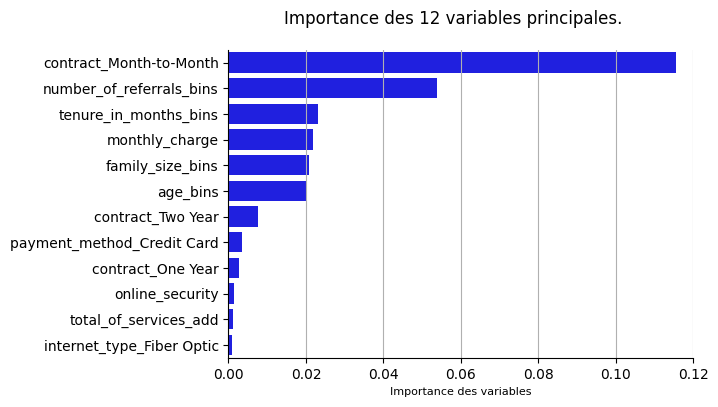

In [24]:
# Création d'un barplot affichant les 12 plus importantes features selon la méthode
# Permutation Feature Importance

# Initialisation de la figure
fig, ax = plt.subplots(figsize=(6, 4))

n = 12 # Définition du nombre de variables à représenter

# barplot des 12 1eres features classées selon leur importance
sns.barplot(x="importance", y="names",
            data=feature_importance.sort_values(by = "importance", ascending = False).head(n=n),
            color="b")

# Gestion des axes
ax.set_xlim(0, 0.12)
ax.set_xlabel("Importance des variables", fontsize = 8)
ax.set_ylabel("")

# Ajout des lignes horizontales
ax.grid(visible=True, which='major', axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Ajout du titre principal
fig.suptitle(f'Importance des {n} variables principales.')
fig.show()

Ce graphique nous permet d’obtenir un premier éclairage sur les features les plus importantes à considérer pour évaluer la fragilité d’un client.

Nous retrouvons en tête de liste 3 variables relatives à l’engagement, à savoir :
* le type de contrat auquel il a souscrit et plus particulièrement si le contrat est mensuel sans engagement
* le nombre de personnes qu’il parraine
* son ancienneté en tant que client de l’entreprise.

Les variables socio-démographique telles que son âge et la taille de sa famille, ainsi que sa facture actuelle mensuelle ont également une place importante selon notre modèle à anticiper la capacité de churn de client.

Les autres prédicteurs semblent avoir un impact plus mineur.


## 3.2 Analyse global selon SHAP

Afin de compléter l'analyse ci-dessous nous calculons les valeurs de SHAP.

In [25]:
# calcul des valeurs de SHAP
shap_explainer = TreeExplainer(model = xgb_clf)
shap_values = shap_explainer(X_test_prepro)

/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/ENV_SC/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[12:36:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "classifier__eta", "classifier__lambda", "classifier__max_depth", "classifier__n_estimators" } are not used.




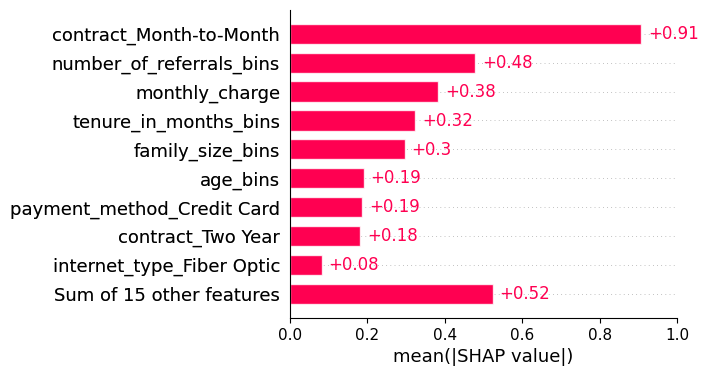

/tmp/ipykernel_10919/86122383.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [26]:
# Représentation graphique de la moyenne de la valeur absolue SHAP pour chaque variables sur l'ensemble du set de test.
fig, ax1 = plt.subplots( figsize=(5,4))
bar(shap_values, ax =ax1)
fig.show()

La représentation graphique de la moyenne de la valeur absolue SHAP pour chaque variables sur l'ensemble du set de test vient confirmer les résultats de l'importance des variables par permutation.

Nous y retrouvons globalement les mêmes top 6 variables de plus forte importance. Nous pouvons néanmoins noter que la technique SHAP attribue une importance un peu plus prononcée aux charges mensuelles, et une importance plus faible de la catégorie d'âge.

Regardons plus en détail la représentation graphique résumant la distribution des valeurs SHAP en fonction des valeurs de chaque variable :

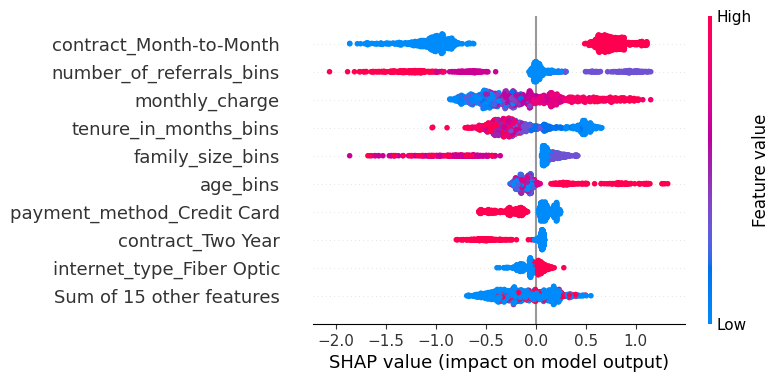

In [27]:
# Représentation graphique résumant la distribution des valeurs SHAP en fonction des valeurs de chaque variable
beeswarm(shap_values, plot_size=(6,4))

In [28]:
variables = {"number_of_referrals_bins" : {"legend" : "Nombre de parrainage", "bins" : ["0", "1", "2-4", ">=5"]},
            "family_size_bins" : {"legend" : "Taille de la famille", "bins" : ["1","2","2-4", "> 4"]},
             "age_bins" : {"legend" : "Age (ans)", "bins" : ["< 30","30-40","40-50", "50-65", "> 65"]},
            "tenure_in_months_bins" : {"legend" : "Ancienneté (en mois)",
                                       "bins" : ['0-6 mois', '7-12 mois', '1-2 ans', '2-3 ans', '3-4 ans', '4-5 ans', "> 5ans"]},
            "monthly_charge" : {"legend" : "Facturation mensuelle normalisée centrée"}}

In [29]:
# Scatter plot des valeurs SHAP en fonction de la variable var
def plot_shap_scatter(var, ax1, legend, bin = None) :
    # Création du scatterplot
    scatter(shap_values[:, var],ax =ax1, show =False)

    # # Modification des étiquettes des axes
    ax1.set_xlabel(legend, fontsize = 9)
    ax1.set_ylabel('Valeur SHAP', fontsize = 9)
    if bin is not None :
        custom_labels = bin
        ax1.set_xticks(range(len(custom_labels)))
        ax1.set_xticklabels(custom_labels)
    if var == "tenure_in_months_bins" :
        ax1.set_xticklabels(custom_labels, rotation=45)
    return ax1

/tmp/ipykernel_10919/971125453.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



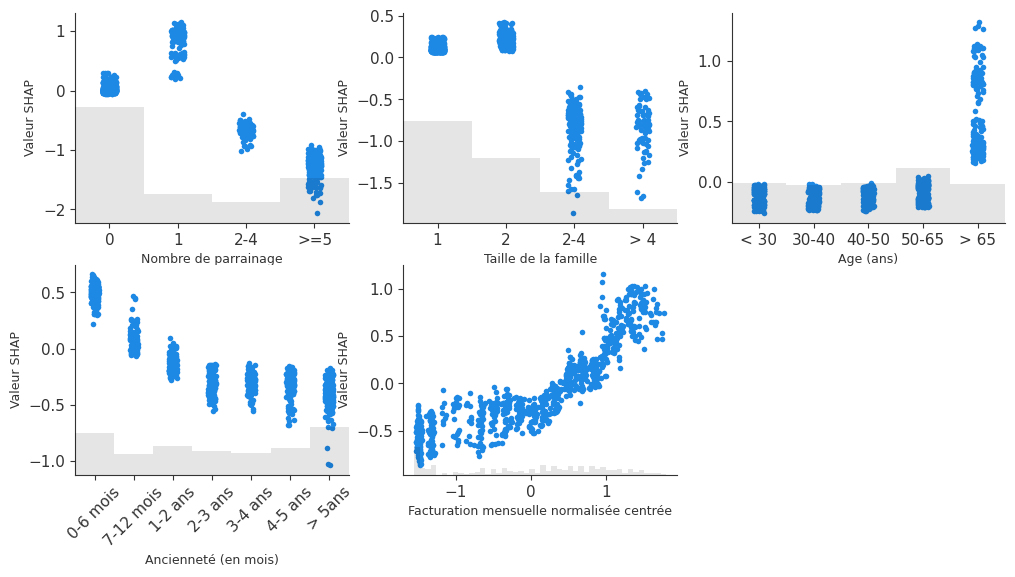

In [32]:
# Visualisation des valeurs SHAP vs les ["number_of_referrals_bins",
# "family_size_bins, "age_bins", "tenure_in_months", "monthly_charge"]
# sous la forme d'un scatterplot
fig, ax1 = plt.subplots(ncols = 3, nrows = 2 ,figsize=(12,6))
(i,j) = (0,0)
for var in variables :
    if j == 3:
        j = 0
        i += 1
    # Créez la figure et les axes à l'avance
    if var == "monthly_charge" :
        bin = None
    else :
        bin = variables[var]["bins"]
    ax1[i,j] = plot_shap_scatter(var ,ax1[i,j],variables[var]["legend"], bin = bin)
    j += 1
ax1[i,j].set_axis_off()
fig.show()
fig.savefig('SHAP_per_var.png')

Les illustrations graphiques ci-dessus indiquent que :
* Le fait d'avoir un contrat mensuel sans engagement influence positivement la fragilité des clients
* Concernant le nombre de parrainages :
* * pour 2 parrainages ou plus, la fidélité du client est renforcée
* * Le fait de ne parrainer personne, n'influence que peu la fragilité du client
* * Par contre, 1 parrainage tend à favoriser le churn.
* Nous remarquons également que l'importance des valeurs SHAP est proportionnelle aux charges mensuelles payées
* Les personnes clientes depuis moins d'un an sont plus disposées à résilier leur contrat, tandis qu'une durée supérieure tend à renforcer la fidélité des clients.
* Les clients dont la famille comprend plus de 2 personnes sont moins fragiles. En revanche l'effet contraire est renforcé pour une famille de 2 personnes. Cet effet est moins important pour les personnes célibataires.
* Il est très clair également que la catégorie d'âge est un paramètre important. Seule la catégorie des seriors ( > 65 ans) influence positivement les valeurs de SHAP.

Tous ces résultats font sens et ne révèlent aucune incohérence.

# Conclusion

Pour ce projet de scoring, nous avons construit une modélisation prédictive visant à déterminer la fragilité des clients d’une entreprise de télécommunication.

A cet effet, une base de données de clients nous a été fournie pour l’entraînement et l’évaluation de notre stratégie de modélisation.

Des 35 variables initiales regroupant des informations socio-démographiques des clients, ainsi que des données sur leur fidélité, les différents services et contrats pour lesquels ils ont opté et des informations concernant leurs factures, nous avons réduit la base à 12 variables pertinentes. Cette présélection est le résultat d’analyses statistiques bivariées des features mais aussi d’une approche de sélection univariée et multivariée des variables.

Nous avons ensuite entraîné, fine-tuné et calibré un modèle de ML XGBoost, dont les performances s’avèrent bonnes avec un AUC sur la base de test de  0.912, une courbe de calibration correcte et un score de Spiegelhalter de 0.56.
De plus, la courbe de lift résultante indique qu'en ciblant 10% des clients, on parvient à identifier 33.1% des clients possiblement fragiles.

Une étude plus approfondie nous a permis d'interpréter les résultats de notre modèle en indiquant que le degré de fragilité des clients de l’entreprise est étroitement lié à leur fidélité et à leur engagement vis à vis de l’entreprise : les clients ayant souscrit à un contrat mensuel, n’ayant parrainé qu’une seule personne et ayant une ancienneté de moins d'un an sont plus susceptibles de résilier leur contrat.
Nous avons également decelé que les clients séniors ainsi que les clients sans enfant à charge sont possiblement plus fragiles.